### Test to evaluate the use of global mass fraction in tracer solution

The discretized mass conservation equation of a component X can be written as 
\begin{equation*}
\frac{m_T\phi-m_T^o\phi^o}{\Delta t}=\sum_{faces} \dot{m}_{face}\phi^{up}_{face}+\dot{m}_{comp}\phi_{comp}
\end{equation*}

where
\begin{equation*}
m_T = V_w\rho_w + V_o\rho_o+V_g\rho_g
\end{equation*}
\begin{equation*}
\dot{m} = F_w\rho_w^{up} + F_o\rho_o^{up} + F_g\rho_g^{up}
\end{equation*}

Phase densities and volumes are inputs from a reservoir simulation as well as the phase flow rates between grid blocks and the completion rates.

In [1]:
import numpy as np

# Main inputs
# 1D case in steady state and costant properties
nx = 20
number_of_time_steps = 100
saturation = np.array([1.0, 0.0, 0.0]) # [water, oil, gas]
time_step = 1.0  # d
injector_concentration = [0.1, 0.0, 0.0]  # kg of X / kg of phase [water, oil, gas]
flow_rate = np.array([20.0, 0.0, 0.0])  # [water, oil, gas] in m3/d

# other inputs that change less frequently
L = 3000.0  # m
A = 1.0  # m2
total_volume = L * A  # m3
bulk_volume = total_volume / nx  # m3
porosity = 0.3  # m3 of pore space/ m3 of total volume
pore_volume = porosity * bulk_volume  # m3
density = np.array([1000.0, 800.0, 200.0])  # [water, oil, gas] in kg/m3
injector_cell = 0
producer_cell = nx - 1
injector_rate = - flow_rate
producer_rate = flow_rate

A = np.zeros((nx, nx))
B = np.zeros(nx)
concentration = np.zeros(nx)
concentration_old = np.zeros(nx)

# steady state for now
density_old = density
saturation_old = saturation
pore_volume_old = pore_volume

In [2]:
def accumulation_term():
    global A, B
    for i in range(nx):
        total_mass = np.sum(pore_volume * saturation * density)
        total_mass_old = np.sum(pore_volume_old * saturation_old * density_old)
        A[i,i] += total_mass
        B[i] += total_mass_old * concentration_old[i]

In [3]:
def completions_term():
    global A, B
    # injection
    B[injector_cell] += -np.sum(injector_rate * density * injector_concentration) * time_step
    # production
    A[producer_cell, producer_cell] += np.sum(producer_rate * density) * time_step

In [4]:
def flow_term():
    global A
    for i in range(nx-1):
        cell_from = i
        cell_to = i + 1
        total_mass = np.sum(flow_rate * density) * time_step
        
        A[cell_from, cell_from] += total_mass
        A[cell_to, cell_from] += -total_mass

In [5]:
def assemble_linear_system():
    global A, B
    A = np.zeros((nx, nx))
    B = np.zeros(nx)
    accumulation_term()
    completions_term()
    flow_term()

In [6]:
def print_balance_error(cell):
    injected_mass = 0.0
    if cell == injector_cell:
        injected_mass = abs(np.sum(injector_rate * density * injector_concentration) * time_step)
        
    produced_mass = 0.0
    if cell == producer_cell:
        produced_mass = np.sum(producer_rate * density * injector_concentration) * time_step
        
    flow_plus = 0.0
    if cell < nx-1:
        flow_plus = np.sum(flow_rate * density) * time_step * concentration[cell]
        
    flow_minus = 0.0
    if cell > 0:
        flow_plus = np.sum(flow_rate * density) * time_step * concentration[cell-1]
        
    total_mass = np.sum(pore_volume * saturation * density) * concentration[cell]
    total_mass_old = np.sum(pore_volume_old * saturation_old * density_old) * concentration_old[cell]
    change_in_time = total_mass - total_mass_old
    balance_error = change_in_time - flow_minus - injected_mass + produced_mass + flow_plus
    phase_mass = pore_volume * saturation * density
    print(
    """
    Phase mass: %s kg
    Component X concentration: %f kg/kg
    \tInjected mass: %f kg
    \tProduced mass: %f kg
    \tMass on I+ face: %f kg
    \tMass on I- face: %f kg
    \tChange of mass in time: %f kg (%f - %f)
    \tBalance error: %f kg
    """
    % (phase_mass, concentration[cell], injected_mass, produced_mass, flow_plus, flow_minus, change_in_time, total_mass, total_mass_old, balance_error))

<IPython.core.display.Javascript object>


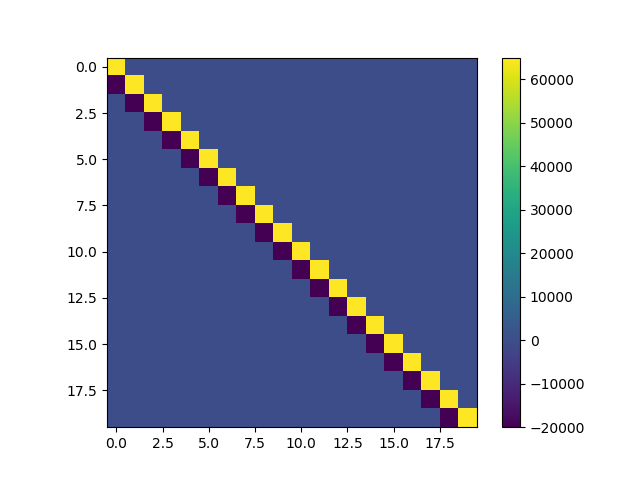

In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# assemble the matrix just for visualization purposes, so we can see the coefficients in their places
assemble_linear_system()

plt.imshow(A)
plt.colorbar()
plt.show()

In [8]:
solutions = []
solutions.append(concentration)
def solve():
    global concentration, concentration_old
    for time in range(number_of_time_steps):
        assemble_linear_system()
        concentration = np.linalg.solve(A, B)
        print_balance_error(0)
        solutions.append(concentration)
        concentration_old = np.copy(concentration)

In [9]:
solve()


    Phase mass: [45000.     0.     0.] kg
    Component X concentration: 0.030769 kg/kg
    	Injected mass: 2000.000000 kg
    	Produced mass: 0.000000 kg
    	Mass on I+ face: 615.384615 kg
    	Mass on I- face: 0.000000 kg
    	Change of mass in time: 1384.615385 kg (1384.615385 - 0.000000)
    	Balance error: 0.000000 kg
    

    Phase mass: [45000.     0.     0.] kg
    Component X concentration: 0.052071 kg/kg
    	Injected mass: 2000.000000 kg
    	Produced mass: 0.000000 kg
    	Mass on I+ face: 1041.420118 kg
    	Mass on I- face: 0.000000 kg
    	Change of mass in time: 958.579882 kg (2343.195266 - 1384.615385)
    	Balance error: 0.000000 kg
    

    Phase mass: [45000.     0.     0.] kg
    Component X concentration: 0.066818 kg/kg
    	Injected mass: 2000.000000 kg
    	Produced mass: 0.000000 kg
    	Mass on I+ face: 1336.367774 kg
    	Mass on I- face: 0.000000 kg
    	Change of mass in time: 663.632226 kg (3006.827492 - 2343.195266)
    	Balance error: 0.000000 kg
   

<IPython.core.display.Javascript object>


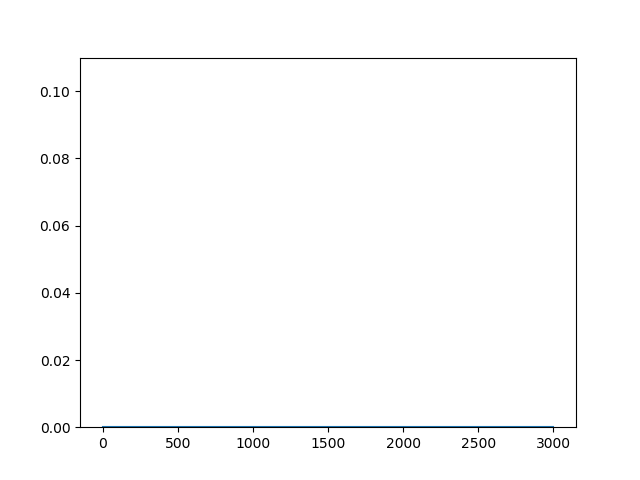

interactive(children=(IntSlider(value=0, description='x'), Output()), _dom_classes=('widget-interact',))

<function __main__.update(x=0)>

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import *

x = np.linspace(0, L, nx)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set(ylim=(0, 1.1*np.max(injector_concentration)))
line, = ax.plot(x, solutions[0])

def update(x = 0):
    line.set_ydata(solutions[x])
    fig.canvas.draw_idle()

interact(update, x=widgets.IntSlider(min=0, max=len(solutions)-1, step=1, value=0))